In this draft, we apply the tau-star association to evaluate the marginal association of genes in a dataset with 20 genes. Of course, in reality correlation between many more genes is of interest, but here for illustration purposes we choose a small sample.

First import the required libraries

In [1]:
import numpy as np
import pandas as pd 

from operator import itemgetter
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import statsmodels.stats.multitest as ssm 
import similarity

Read in the data:

In [2]:
df = pd.read_csv("./TCGA-PANCAN-HiSeq-801x20531/sample20.csv", sep=",")
# print(np.sum(df.isnull().values))

data = np.array(df)[:, 1:]
n, p = data.shape
q = .2

To visualize the data, we plot the bar graph of distribution of zeros in the data matrix.

In [3]:
non_zeros_features = np.round(100. * (data == 0.).sum(0)/n)

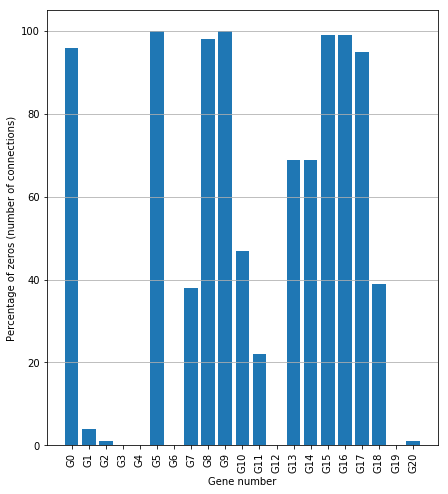

In [5]:
fig = plt.gcf()
fig.set_size_inches(7, 8)
plt.bar(np.arange(p), non_zeros_features)
plt.xticks(np.arange(p), ["G"+str(j) for j in np.arange(p)], rotation='vertical')
plt.xlabel("Gene number")
plt.ylabel("Percentage of zeros (number of connections)")
plt.grid(axis="y")

plt.show()

For each pair of nodes, we evaluate the taustar association:

In [6]:
BH_tau_ = []
BH_tau_index = []

for i in range(p):
    for j in range(p):
        if i < j:
            temp = similarity.taustar(data[:, i], data[:, j], pval=True)
            BH_tau_ += [temp]
            BH_tau_index += [(i, j)]

BH_tau = np.array(BH_tau_) 

In [7]:
tau = BH_tau[:, 0]
tau[np.isnan(tau)] = 0.#Not needed though
pval = BH_tau[:, 1]

We can filter the connection using the Benjamini-Hochberg method of FDR control

In [ ]:
BH_adj_pval = ssm.multipletests(pval, alpha=q, method="fdr_bh")[0]

The indeces, and the pairs of connections can be gotten from the below codes.

In [10]:
S_BH = [idx for idx, boolian in enumerate(BH_adj_pval) if boolian == True]
sel_dependences = [BH_tau_index[x] for x in S_BH]

involved_nodes = np.array([i for i, j in sel_dependences] + [j for i, j in sel_dependences])
nodes_no_connection = [j for j in range(p) if j not in np.unique(involved_nodes)]
unique, node_connections_number_ = np.unique(involved_nodes, return_counts=True)

node_connections_number1 = []
for i, j in zip(unique, node_connections_number_):
    node_connections_number1 += [[i, j]]

node_connections_number0 = [[i, 0] for i in nodes_no_connection]
node_connections_number2 = node_connections_number0 + node_connections_number1
node_connections_number__ = np.array(node_connections_number2)
node_connections_number = node_connections_number__[np.argsort(node_connections_number__[:, 0])]
node_connections_number = node_connections_number[:, 1]

print("------------Selected connections----------")
print(sel_dependences)
print("------------nodes without any connection----------")
print(len(BH_tau_index))
print("Number of nodes: " + str(p))
print('---------------------')
print("Number of edges: " + str(len(sel_dependences)))

------------Selected connections----------
[(0, 3), (0, 4), (0, 5), (0, 12), (0, 18), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 10), (1, 11), (1, 14), (1, 18), (1, 19), (1, 20), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 11), (2, 17), (2, 18), (2, 19), (2, 20), (3, 4), (3, 5), (3, 6), (3, 7), (3, 10), (3, 13), (3, 14), (3, 16), (3, 18), (3, 19), (3, 20), (4, 5), (4, 6), (4, 7), (4, 9), (4, 10), (4, 12), (4, 14), (4, 15), (4, 18), (4, 19), (4, 20), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (6, 7), (6, 10), (6, 11), (6, 12), (6, 13), (6, 15), (6, 18), (6, 19), (6, 20), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 16), (7, 18), (7, 19), (7, 20), (8, 10), (8, 13), (8, 15), (10, 11), (10, 13), (10, 14), (10, 18), (10, 19), (11, 12), (11, 13), (11, 18), (11, 20), (12, 13), (12, 19), (12, 20), (13, 19), (13, 20), (14, 15), (14, 18), (14, 19), (14, 20), (15, 18), (17, 18), (18, 19), (18, 20)

To plot the final undirected graph, we use the networkx library.

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


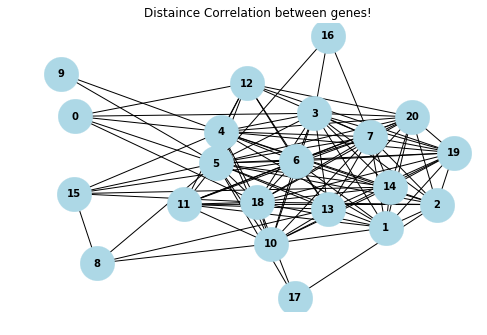

In [9]:
# ------- UNDIRECTED
np.random.seed(123+(4)**2)
G = nx.Graph()

G.add_nodes_from(involved_nodes)
G.add_edges_from(sel_dependences)
# G.add_weighted_edges_from([(0, 3, 5.9),(2, 4, 2.5)])

pos = nx.spring_layout(G,k=0.95,iterations=20)

# Build your graph. Note that we use the Graph function to create the graph!
# nx.draw(G, with_labels=True, node_size=500, alpha=.9, node_color="red", edge_color="black",pos=pos)



nx.draw(G, pos=graphviz_layout(G), node_size=1200, node_color='lightblue',
    linewidths=0.25, font_size=10, font_weight='bold', with_labels=True, dpi=1000)

# Make the graphnx.draw(G, with_labels=True, node_size=1500, alpha=0.3, arrows=True)
plt.title("Distaince Correlation between genes!")

plt.show()